# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
!pip install pandas statsmodels

In [2]:
!pip install phik

In [3]:
!pip install --upgrade scikit-learn

In [4]:
import sklearn
print(sklearn.__version__)

1.5.2


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgb
from phik import phik_matrix
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import time
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [6]:
data = pd.read_csv('/datasets/autos.csv')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [8]:
import re

def camel_to_snake(name):
    name_snake = re.sub(r'(?<!^)(?=[A-Z])', '_',
                        name).lower()
   
    return name_snake
                        

In [9]:
columns = ['''DateCrawled, Price, VehicleType,\
RegistrationYear, Gearbox, Power, Model,\ 
Kilometer, RegistrationMonth,\ 
FuelType, Brand, Repaired, DateCreated,\ 
NumberOfPictures, PostalCode, LastSeen''']

In [10]:
columns_snake = [camel_to_snake(col) for
                 col in columns]
columns_snake

['date_crawled, _price, _vehicle_type,_registration_year, _gearbox, _power, _model,\\ \n_kilometer, _registration_month,\\ \n_fuel_type, _brand, _repaired, _date_created,\\ \n_number_of_pictures, _postal_code, _last_seen']

In [11]:
data = data.rename(columns=lambda x:\
camel_to_snake(x))

In [12]:
data.head(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [13]:
data.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [14]:
data = data.drop('number_of_pictures', axis = 1)

In [15]:
data.head(2)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,66954,2016-04-07 01:46:50


In [16]:
data.isnull().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
postal_code               0
last_seen                 0
dtype: int64

In [17]:
mode_df = data.groupby('model')['fuel_type'].\
agg(lambda x: x.mode()[0] if not x.mode().\
    empty else None).reset_index()
mode_df.columns = ['model', 'mode_fuel_type']


data = pd.merge(data, mode_df, on='model', how='left')

data['fuel_type'] = data['fuel_type'].\
fillna(data['mode_fuel_type'])

data = data.drop(columns=['mode_fuel_type'])

data.isnull().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type              7163
brand                     0
repaired              71154
date_created              0
postal_code               0
last_seen                 0
dtype: int64

В столбце fuel type удалось сократить пропуски пимерно на 25 000.

In [18]:
mode_df = data.groupby('model')['gearbox'].\
agg(lambda x: x.mode()[0] if not x.mode().\
    empty else None).reset_index()
mode_df.columns = ['model', 'mode_gearbox']


data = pd.merge(data, mode_df, on='model', how='left')


data['gearbox'] = data['gearbox'].\
fillna(data['mode_gearbox'])

data = data.drop(columns=['mode_gearbox'])

data.isnull().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox                4131
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type              7163
brand                     0
repaired              71154
date_created              0
postal_code               0
last_seen                 0
dtype: int64

In [19]:
mode_df = data.groupby('model')['vehicle_type'].\
agg(lambda x: x.mode()[0] if not x.mode().\
    empty else None).reset_index()
mode_df.columns = ['model', 'mode_vehicle_type']


data = pd.merge(data, mode_df, on='model', how='left')


data['vehicle_type'] = data['vehicle_type'].\
fillna(data['mode_vehicle_type'])


data = data.drop(columns=['mode_vehicle_type'])

data.isnull().sum()

date_crawled              0
price                     0
vehicle_type           6828
registration_year         0
gearbox                4131
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type              7163
brand                     0
repaired              71154
date_created              0
postal_code               0
last_seen                 0
dtype: int64

In [20]:
df_repaired = data[data['repaired'].str.lower() == 'yes']
repair_counts = df_repaired['registration_year'].\
value_counts().sort_values(ascending=False)

display(repair_counts.head(20))

1999    3254
2000    3224
1998    2728
2001    2511
1997    2363
2002    2043
2003    1978
2005    1889
2004    1681
1996    1646
2006    1442
1995    1432
2016    1310
2007    1115
2017    1022
2008     817
2009     744
1994     734
1993     517
2010     453
Name: registration_year, dtype: int64

In [21]:
data = data.dropna()

data.isnull().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
postal_code           0
last_seen             0
dtype: int64

In [22]:
def fill_repaired(row):
    if pd.isnull(row['repaired']):
        if 2000 <= row['registration_year'] <= 2005:
            return 'yes'
        else:
            return 'no'
    return row['repaired']

data['repaired'] = data.apply(fill_repaired, axis=1)

data.isnull().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
postal_code           0
last_seen             0
dtype: int64

In [23]:
data = data[(data['registration_year'] >=1885)&\
           (data['registration_year'] <2016)]

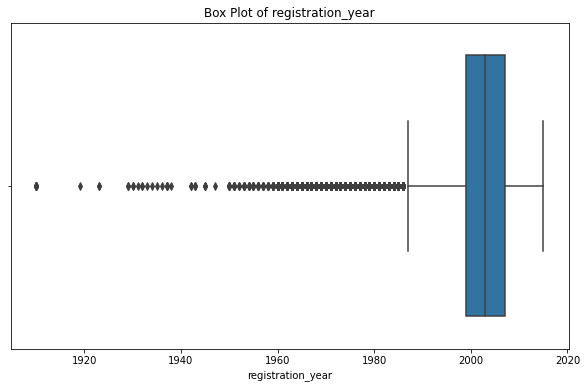

In [24]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['registration_year'])
plt.xlabel('registration_year')
plt.title('Box Plot of registration_year')
plt.show()

In [25]:
data = data[(data['registration_year'] >=1982)]

In [26]:
data = data[(data['price'] >0)]

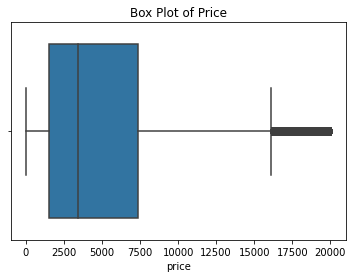

In [27]:
sns.boxplot(x=data['price'])
plt.xlabel('price')
plt.title('Box Plot of Price')
plt.show()

Выбросы в цене автомобиля есть по верхнему порогу, но удалять я их не буду, так как это могут быть автомобили сегмента люкс.

In [28]:
def fill_random_month(df, column_name):
    df[column_name] = df[column_name].apply(lambda x:
    np.random.randint(1, 13) if x == 0 else x)
    
fill_random_month(data, 'registration_month')
data['registration_month'].unique()

array([ 6,  7, 10,  8, 12,  2,  3,  1,  4,  5,  9, 11])

In [29]:
data = data[(data['power'] >0)]


In [30]:
data = data.drop(['postal_code'], axis=1)

<AxesSubplot:>

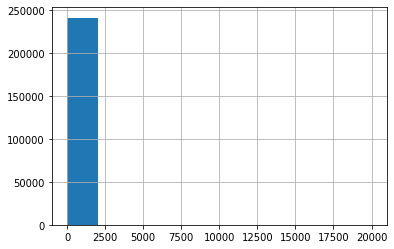

In [31]:
data.power.hist()

In [32]:
data = data.loc[data['power'] <= 700]

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241179 entries, 3 to 354367
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        241179 non-null  object
 1   price               241179 non-null  int64 
 2   vehicle_type        241179 non-null  object
 3   registration_year   241179 non-null  int64 
 4   gearbox             241179 non-null  object
 5   power               241179 non-null  int64 
 6   model               241179 non-null  object
 7   kilometer           241179 non-null  int64 
 8   registration_month  241179 non-null  int64 
 9   fuel_type           241179 non-null  object
 10  brand               241179 non-null  object
 11  repaired            241179 non-null  object
 12  date_created        241179 non-null  object
 13  last_seen           241179 non-null  object
dtypes: int64(5), object(9)
memory usage: 27.6+ MB


In [34]:
data.duplicated().sum()

5

In [35]:
data = data.drop_duplicates().reset_index(drop=True)

data.duplicated().sum()

0

In [36]:
data = data.drop(['last_seen'], axis = 1)

In [37]:
data['date_created'] = pd.to_datetime(data['date_created'])

In [38]:
data['date_created'].dtype

dtype('<M8[ns]')

In [39]:
data['year_created'] = data['date_created'].dt.year
data.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,year_created
0,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,2016
1,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,2016
2,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,2016
3,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01,2016
4,2016-03-26 19:54:18,2000,sedan,2004,manual,105,3_reihe,150000,12,petrol,mazda,no,2016-03-26,2016


In [40]:
data = data.drop(['date_crawled'], axis = 1)

In [41]:
data = data.drop(['date_created'], axis = 1)

In [42]:
data['fuel_type'] = data['fuel_type'].replace('gasoline','petrol')
data['fuel_type'].unique()

array(['petrol', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

In [43]:
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    '''
    Function optimizes memory usage in dataframe
    df: pd.DataFrame - data table
    print_size: bool - display of optimization results
    return pd.DataFrame - amount of optimized memory
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = data.memory_usage().sum() / 1024**2    
    for column in data.columns:
        column_type = data[column].dtypes
        if column_type in numerics:
            column_min = data[column].min()
            column_max = data[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    data[column] = data[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    data[column] = data[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    data[column] = data[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    data[column] = data[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    data[column] = data[column].astype(np.float32)
                else:
                    data[column] = data[column].astype(np.float64)    
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = data.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                         .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return data

На текущем этапе работы я завершила загрузку всех необходимых библиотек и загрузку данных. Я провела предобработку данных, включая заполнение пропусков в столбцах, таких как тип коробки передач и тип топлива, на основе имеющихся данных о моделях автомобилей. В отношении пропусков в столбце, указывающем на то, была ли машина отремонтирована (Repaired), я проанализировала года выпуска машин, которые наиболее часто ломаются. На основе этого анализа я использовала следующую логику: если машина с пропуском относится к году, когда ремонт был более вероятен, я установила значение “Yes”. В противном случае, если год не относится к этому диапазону, вероятность ремонта была ниже, и я установила значение “No”. Пропуски, которые не удалось заполнить, были удалены. Также я исключила из анализа неинформативные для меня столбцы, такие как изображения  и почтовый код.

In [44]:
data = data.drop(['registration_month'], axis = 1)
data = data.drop(['year_created'], axis = 1)

interval columns not set, guessing: ['price', 'registration_year', 'power', 'kilometer']
Матрица корреляций:
                      price  vehicle_type  registration_year   gearbox  \
price              1.000000      0.265934           0.706631  0.321847   
vehicle_type       0.265934      1.000000           0.179218  0.276722   
registration_year  0.706631      0.179218           1.000000  0.126241   
gearbox            0.321847      0.276722           0.126241  1.000000   
power              0.520858      0.480553           0.290031  0.561800   
model              0.579606      0.925680           0.642654  0.657226   
kilometer          0.318405      0.183448           0.485727  0.028387   
fuel_type          0.047201      0.069387           0.069717  0.094633   
brand              0.341331      0.609759           0.327714  0.503598   
repaired           0.355651      0.075903           0.207139  0.036352   

                      power     model  kilometer  fuel_type     brand  \
pri

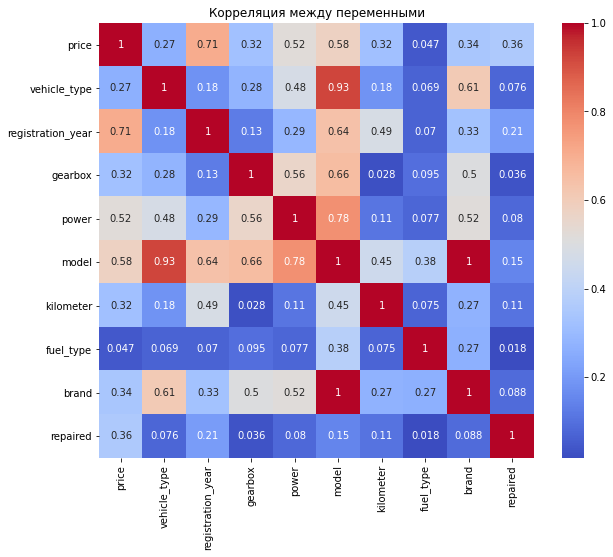

In [45]:
correlation_matrix = data.phik_matrix()
print("Матрица корреляций:")
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Корреляция между переменными')
plt.show()

Посмотрев на связь бренда и модели, значение 1 указывает на сильную положительную корреляцию между двумя переменными. 

In [46]:
data = data.drop(['model'], axis = 1)

## Обучение моделей

In [47]:
data.head()

,price,vehicle_type,registration_year,gearbox,power,kilometer,fuel_type,brand,repaired
0,1500,small,2001,manual,75,150000,petrol,volkswagen,no
1,3600,small,2008,manual,69,90000,petrol,skoda,no
2,650,sedan,1995,manual,102,150000,petrol,bmw,yes
3,2200,convertible,2004,manual,109,150000,petrol,peugeot,no
4,2000,sedan,2004,manual,105,150000,petrol,mazda,no


In [69]:
# Определяем числовые и категориальные признаки
numeric_features = ['registration_year', 'power', 'kilometer']
categorical_features = ['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired']

# Разделение данных на признаки и целевую переменную
X = data[numeric_features + categorical_features]
y = data['price']

# Разделение на тренировочный, тестовый и валидационный наборы данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Создание пайплайнов для числовых и категориальных данных
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

# Объединение трансформеров с помощью ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Создание пайплайна с Ridge-регрессией
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('ridge', Ridge())])

# Подбор гиперпараметров с помощью GridSearchCV
param_grid = {
    'ridge__alpha': [0.1, 1.0, 10.0]  
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5)

# Обучение модели
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()
training_time_ridge = end_time - start_time

start_prediction_time = time.time()  # Начало отсчета времени предсказания
val_predictions_ridge = grid_search.predict(X_valid)
end_prediction_time = time.time() 
prediction_time_ridge = end_prediction_time - start_prediction_time

rmse_ridge = np.sqrt(mean_squared_error(y_valid, val_predictions_ridge))

print("Лучшие гиперпараметры: ", grid_search.best_params_)
print("RMSE Ridge на валидационной выборке: %.2f" % rmse_ridge)
print(f"Время обучения модели: {end_time - start_time:.2f} секунд")
print(f"Время предсказания модели: {end_prediction_time - start_prediction_time:.2f} секунд")


Лучшие гиперпараметры:  {'ridge__alpha': 0.1}
RMSE Ridge на валидационной выборке: 2521.60
Время обучения модели: 35.45 секунд
Время предсказания модели: 0.20 секунд


In [52]:
data['vehicle_type'] = data['vehicle_type'].astype('category').cat.codes
data['gearbox'] = data['gearbox'].astype('category').cat.codes
data['fuel_type'] = data['fuel_type'].astype('category').cat.codes
data['brand'] = data['brand'].astype('category').cat.codes
data['repaired'] = data['repaired'].astype('category').cat.codes

# Разделение данных на признаки и целевую переменную
X = data[numeric_features + categorical_features]
y = data['price']

# Разделение на тренировочный, тестовый и валидационный наборы данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [53]:
start_time = time.time()

params = {
    'boosting_type': 'dart',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 25,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 6,
    'verbose': 0,
    'n_jobs': -1
}

lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_valid, y_valid)

model_lgb = lgb.train(params,
                      lgb_train,
                      num_boost_round=1400,
                      valid_sets=[lgb_train, lgb_val],
                      early_stopping_rounds=50,
                      verbose_eval=120)

end_time = time.time()
training_time_lgb = end_time - start_time



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[120]	training's rmse: 2391.51	valid_1's rmse: 2411.82
[240]	training's rmse: 1925.29	valid_1's rmse: 1950.04
[360]	training's rmse: 1826.67	valid_1's rmse: 1855.35
[480]	training's rmse: 1741.29	valid_1's rmse: 1774.53
[600]	training's rmse: 1735.53	valid_1's rmse: 1770.18
[720]	training's rmse: 1704.89	valid_1's rmse: 1742.75
[840]	training's rmse: 1673.99	valid_1's rmse: 1715.49
[960]	training's rmse: 1662.13	valid_1's rmse: 1705.61
[1080]	training's rmse: 1651.36	valid_1's rmse: 1697.48
[1200]	training's rmse: 1645.59	valid_1's rmse: 1692.78
[1320]	training's rmse: 1633.54	valid_1's rmse: 1683.03


In [54]:
print("Время обучения LightGBM: %s секунд" % training_time_lgb)

start_time = time.time()
y_pred_lgb = model_lgb.predict(X_test)
end_time = time.time()
prediction_time_lgb = end_time - start_time
print("Время предсказания LightGBM: %s секунд" % prediction_time_lgb)

rmse_lgb = mean_squared_error(y_valid, model_lgb.predict(X_valid), squared=False)
print("RMSE LightGBM на валидационной выборке: %.2f" % rmse_lgb)

Время обучения LightGBM: 1241.2170622348785 секунд
Время предсказания LightGBM: 7.63558554649353 секунд
RMSE LightGBM на валидационной выборке: 1671.22


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [55]:
start_time = time.time()

model_catboost = CatBoostRegressor(iterations=1200,
                                   learning_rate=0.1,
                                   depth=4,
                                   loss_function='RMSE',
                                   random_state=42)

model_catboost.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=120, early_stopping_rounds=50)

end_time = time.time()
print("Время обучения LightGBM: %s секунд" % training_time_lgb)

start_time = time.time()
y_pred_lgb = model_lgb.predict(X_test)
end_time = time.time()
prediction_time_lgb = end_time - start_time
print("Время предсказания LightGBM: %s секунд" % prediction_time_lgb)

rmse_lgb = mean_squared_error(y_valid, model_lgb.predict(X_valid), squared=False)
print("RMSE LightGBM на валидационной выборке: %.2f" % rmse_lgb)
training_time_catboost = end_time - start_time




0:	learn: 4385.9138316	test: 4408.3044218	best: 4408.3044218 (0)	total: 73ms	remaining: 1m 27s
120:	learn: 1831.1517996	test: 1852.9876999	best: 1852.9876999 (120)	total: 2.16s	remaining: 19.2s
240:	learn: 1749.1138134	test: 1773.8755453	best: 1773.8755453 (240)	total: 4.31s	remaining: 17.1s
360:	learn: 1712.0116024	test: 1740.2013549	best: 1740.2013549 (360)	total: 6.42s	remaining: 14.9s
480:	learn: 1686.5109931	test: 1719.7765357	best: 1719.7765357 (480)	total: 8.49s	remaining: 12.7s
600:	learn: 1668.5575648	test: 1707.1199584	best: 1707.1199584 (600)	total: 10.5s	remaining: 10.5s
720:	learn: 1654.9711884	test: 1697.8229199	best: 1697.8229199 (720)	total: 12.6s	remaining: 8.35s
840:	learn: 1643.5399516	test: 1690.1181987	best: 1690.1181987 (840)	total: 14.6s	remaining: 6.24s
960:	learn: 1632.9481856	test: 1683.6367739	best: 1683.6367739 (960)	total: 16.7s	remaining: 4.14s
1080:	learn: 1624.7746348	test: 1678.3013344	best: 1678.3013344 (1080)	total: 18.7s	remaining: 2.06s
1199:	learn:

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [56]:
print("Время обучения CatBoostRegressor: %s секунд" % training_time_catboost)

start_time = time.time()
y_pred_catboost = model_catboost.predict(X_test)
end_time = time.time()

prediction_time_catboost = end_time - start_time
print("Время предсказания CatBoostRegressor: %s секунд" % prediction_time_catboost)

rmse_catboost = mean_squared_error(y_valid, model_catboost.predict(X_valid), squared=False)
print("RMSE CatBoostRegressor на валидационной выборке: %.2f" % rmse_catboost)

Время обучения CatBoostRegressor: 7.388875961303711 секунд
Время предсказания CatBoostRegressor: 0.054340362548828125 секунд
RMSE CatBoostRegressor на валидационной выборке: 1672.53


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [57]:
start_time = time.time()
param_grid = {'n_estimators': [100, 500, 1000]}
model_xgb = XGBRegressor(random_state=42)
                         
grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=3, verbose=1)

start_time = time.time()
grid_search.fit(X_train, y_train)

end_time = time.time()
training_time_xgb = end_time - start_time
print("Время обучения XGBRegressor с GridSearchCV: %s секунд" % training_time_xgb)

best_model_xgb = grid_search.best_estimator_
print("Лучшие гиперпараметры: ", grid_search.best_params_)


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Время обучения XGBRegressor с GridSearchCV: 1369.823406457901 секунд
Лучшие гиперпараметры:  {'n_estimators': 500}


In [58]:
y_pred_xgb = best_model_xgb.predict(X_valid)

rmse_xgb = mean_squared_error(y_valid, y_pred_xgb, squared=False)
print("RMSE XGBRegressor на валидационной выборке: %.2f" % rmse_xgb)

start_time = time.time()
y_pred_xgb_test = best_model_xgb.predict(X_test)
end_time = time.time()
prediction_time_xgb = end_time - start_time
print("Время предсказания XGBRegressor: %s секунд" % prediction_time_xgb)

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE XGBRegressor на валидационной выборке: 1588.93
Время предсказания XGBRegressor: 0.859856367111206 секунд


## Анализ моделей

In [71]:
final_table = pd.DataFrame({'Model': ['Ridge', 'LightGBM', 'CatBoostRegressor', 'XGBRegressor'],
                        'Training Time (sec)': [training_time_ridge, training_time_lgb, training_time_catboost, training_time_xgb],
                        'Prediction Time (sec)': [prediction_time_ridge , prediction_time_lgb, prediction_time_catboost, prediction_time_xgb],
                        'RMSE (Validation)': [rmse_ridge, rmse_lgb, rmse_catboost, rmse_xgb]})

final_table


,Model,Training Time (sec),Prediction Time (sec),RMSE (Validation)
0,Ridge,35.452940,0.198330,2521.597471
1,LightGBM,1241.217062,7.388876,1671.215510
2,CatBoostRegressor,7.388876,0.054340,1672.532105
3,XGBRegressor,1369.823406,0.859856,1588.933281


In [73]:
# Оценка качества модели LightGBM на тестовой выборке
rmse_test = mean_squared_error(y_test, best_model_xgb.predict(X_test), squared=False)
print("RMSE XGBRegressor на тестовой выборке: %.2f" % rmse_test)

RMSE XGBRegressor на тестовой выборке: 1546.80


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


**Вывод**
1. Компания по продаже автомобилей предоставила набор данных, содержащий 15 признаков и около 354 тысяч записей. На этапе предобработки я удалила неинформативные столбцы, заполнила пропущенные значения и устранила выбросы, что позволило очистить и подготовить данные для дальнейшего анализа.  

2. На втором этапе построения моделей я применила линейную регрессию, преобразовав все признаки в числовые значения. В результате на тренировочной выборке сумма квадратов средней ошибки (RMSE) составила 2521. Затем, использовав LightGBM	, удалось снизить RMSE до 1671. CatBoostRegressor	- 1672. В завершение, я применила модель бустинга XGBRegressor, которая показала значение RMSE около 1588.

3. На третьем этапе анализа моделей я оценивала время обучения Ridge показала время предсказания 0.2 секунды. LightGBM	 продемонстрировал время предсказания 7.4 секунд. 	CatBoostRegressor достиг 0.05 секунды, XGBRegressor время - 0.9.

4. Учитывая, что для заказчика важны качество предсказаний, скорость их выполнения и время обучения модели, я предложила использовать XGBRegressor . Этот алгоритм обеспечивает оптимальный баланс между точностью предсказаний, быстротой обучения и выполнения предсказаний.
